In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as col
import math
import pandas as pd
import time

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from math import pi
from IPython.display import clear_output

In [2]:
def ring(data, pixel_size, center_x, center_y, file_count, est_min_rad):

    r_vals = []
    
    r_dict_I = {}
    r_dict_pix = {}
    tic = time.perf_counter()
    y_len = len(data)
    x_len = len(data[1])
    

    

    for y in range(y_len):
        
        for x in range(x_len):

            I = data[y, x]
            

            rx = abs(center_x - x)
            ry = abs(center_y - y)
            r = round(math.sqrt(rx**2 + ry**2))
            r = int(r)


            if r in r_vals:
                #cur_I_sum = r_dict_I[r]
                r_dict_I[r] += I

                #cur_pix_sum = r_dict_pix[r]
                r_dict_pix[r] += 1


            else:
                r_vals.append(r)

                r_dict_I[r] = I


                r_dict_pix[r] = 1

    r_dict_I_sort = sorted(r_dict_I.keys())
    
    r_lst = []
    cul_vals = []
    I_vals = []
    moving_sum = 0
    
   
    for key in r_dict_I_sort:
        if r_dict_I[key] != 0:
            r_cm = pixel_size * key
            r_kpc = round((r_cm * 3.24077928967e-19) / 1e3, 4)

            r_lst.append(r_kpc)
            I_pix = r_dict_I[key] / r_dict_pix[key]
            moving_sum += I_pix
            cul_vals.append(moving_sum)
            I_vals.append(I_pix)
    
        
    max_val = cul_vals[-1]
    norm_cul_vals = []
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
    
    mean = np.mean(I_vals)

   # if file_count < 7:
        
    
    
    # plt.bar(r_lst, norm_cul_vals, width=0.5)
    # plt.plot(r_lst, norm_cul_vals)
    # plt.title("Normalized Cumulative Histogram of Jet Intensities Radially")
    # plt.xlabel("R-Value (kpc)")
    # plt.ylabel("Normalized Cumulative Value")
    # plt.show()
    
    
    max_I = max(I_vals[est_min_rad:])
    max_r_in = I_vals.index(max_I)
    max_r = r_lst[max_r_in]
    
    if round(max_r) == 0:
        
        for value in r_lst:
            if value > 15:
                br = r_lst.index(value)
                break
            else:
                br = 0
                
        max_I = max(I_vals[br:])
        max_r_in = I_vals.index(max_I)
        max_r = r_lst[max_r_in]
        
        print(max_I)
        print(max_r)
        
        # plt.plot(r_lst[br:], I_vals[br:])
        # plt.axhline(y=mean, color='r', linestyle='dashed')
        # plt.title("Jet Intensities Radially")
        # plt.xlabel("R-Value (kpc)")
        # plt.ylabel("Intensity Value")
        # plt.show()
        
    else:
        # plt.plot(r_lst, I_vals)
        # plt.title("Jet Intensities Radially")
        # plt.axhline(y=mean, color='r', linestyle='dashed')
        # plt.xlabel("R-Value (kpc)")
        # plt.ylabel("Intensity Value")
        # plt.show()
        
        print(max_I)
        print(max_r)
    
                
        
        
        
        # 1. Create an array with outliers
        # 2. Determine mean and standard deviation
#         mean = np.mean(I_vals)
# #         std_dev = np.std(I_vals)
# #         # 3. Normalize array around 0
# #         zero_based = abs(I_vals - mean)
# #         # 4. Define maximum number of standard deviations
# #         max_deviations = 0.5



#         no_outliers = []

# #         for i, element in enumerate(zero_based):
# #             if element < max_deviations * std_dev:
# #                 no_outliers.append(I_vals[i])
# #             else:
# #                 no_outliers.append(0)
#         for element in I_vals:
#             if element > mean:
#                 no_outliers.append(np.nan)
#             else:
#                 no_outliers.append(element)
                

#         plt.plot(r_lst, no_outliers)
#         plt.axhline(y=mean, color='r', linestyle='dashed')
#         plt.title("Jet Intensities Radially")
#         plt.xlabel("R-Value (kpc)")
#         plt.ylabel("Intensity Value")
#         plt.show()

    # pixel_count = 0
    # for element in norm_cul_vals:
    #     if element >= 0.02 and element <= 0.98:
    #         pixel_count += 1
            
    # jet_r_cm = pixel_size * pixel_count
    # jet_r_kpc = round((jet_r_cm * 3.24077928967e-19) / 1e3, 4)
    #print("\nTotal Radius (96%): {} kpc".format(jet_r_kpc))
    
    toc = time.perf_counter()
    print("\nCompleted in {} seconds".format(round(toc - tic)))
    
    return_lst = [max_r, max_I]
    
    return return_lst
    
        
    

In [3]:
#Main Calling Block of Code

print("\nJET RING DETERMINING PROGRAM:")
print("{}\n".format("_"*100))
rc = [3, 10, 30, 100]
strengths = [430, 438, 446, 456]

ring_r_mlst = []
ring_I_mlst = []
ring_t_mlst = []
stren_lst = []
rc_lst = []

for stren in strengths:
    for value in rc:
        ring_data = np.array([["Strength", "rc", "Time", "Ring Radius (kpc)", "Maximum Ring Intensity"]])
        path = '**/Group_L{}_rc{}_*nu=30.0*0.00_0.00_1.00*Myr.fits*'.format(stren, value)

        # Determines if there are any files in device
        total_files = len(glob.glob(path, recursive=True))

        if total_files > 0:
            file_count = 0
            for file in sorted(glob.glob(path, recursive=True)):

                file_count += 1

                try:
                    print("File Number {}/{}\n".format(file_count, total_files))
                    #print("File Name: {}".format(file))

                    image_data = fits.getdata(file, ext=0)
                    fits_image_hdul = fits.open(file)

                    #Displays FITS Image title, time index, and pixel size
                    sim_title = fits_image_hdul[0].header['OBJECT']
                    sim_time = fits_image_hdul[0].header['TIME']
                    sim_time = round(float(sim_time[:-4]), 1)

                    pixel = fits_image_hdul[0].header['CDELT1']
                    print("Simulation Title: {}".format(sim_title))
                    #print("Time index: {}".format(sim_time))
                    #print("Pixel size: {}".format(pixel))
                    pixel_size = float(pixel[:-3])

                    center_x = round(float(fits_image_hdul[0].header['CRPIX1']))
                    center_y = round(float(fits_image_hdul[0].header['CRPIX2']))
                    center = (center_x, center_y)
                    print("Center of fits image: {}".format(center))

                    #Difines Data From FITS image and records image dimensions
                    data =  fits_image_hdul[0].data
                    length = len(data[0])
                    width = len(data)
                    #print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

                    for i in range(image_data.shape[0]):
                        for j in range(image_data.shape[1]):
                            if image_data[i, j] == 0:
                                image_data[i, j] = 1e-12


                    plt.figure()
                    plt.imshow(image_data, cmap='hot', norm=col.LogNorm())
                    plt.clim(10e-11, 1e2) 
                    plt.colorbar() 
                    plt.show()

                    answered = False
                    while answered is False:
                        ask = input("Ring? (y/n): ")

                        if ask == "y":
                            answered = True
                            est_min_rad = int(input("Est. Minimum radius? "))
                            return_lst = ring(data, pixel_size, center_x, center_y, file_count, est_min_rad)

                            max_r = return_lst[0]
                            max_I = return_lst[1]

                            cur_data = np.array([stren, value, sim_time, max_r, max_I])
                            ring_data = np.vstack([ring_data, cur_data])

                            clear_output(wait=False)

                        elif ask == "n":
                            answered = True
                            print("skipped")

                            clear_output(wait=False)




                    #print("{}\n".format("_"*100))

                except OSError:
                    print("Error with file: {}".format(file))
                    print("Empty or corrupt FITS file")

            data_table = pd.DataFrame(ring_data)

            print(data_table)

            ring_r = ring_data[1:, 3]
            ring_I = ring_data[1:, 4]
            ring_t = ring_data[1:, 2]
            ring_r_lst = []
            ring_I_lst = []
            ring_t_lst = []

            for i in range(len(ring_r)):
                ring_r_lst.append(float(ring_r[i]))
                ring_I_lst.append(float(ring_I[i]))
                ring_t_lst.append(float(ring_t[i]))

            ring_r_mlst.append(ring_r_lst)
            ring_I_mlst.append(ring_I_lst)
            ring_t_mlst.append(ring_t_lst)
            stren_lst.append(stren)
            rc_lst.append(value)


        else:
            print("ERROR: Could not find any necessary files on your device")
            print("Program intakes files of the name: {}".format(path))



          0   1     2                  3                       4
0  Strength  rc  Time  Ring Radius (kpc)  Maximum Ring Intensity


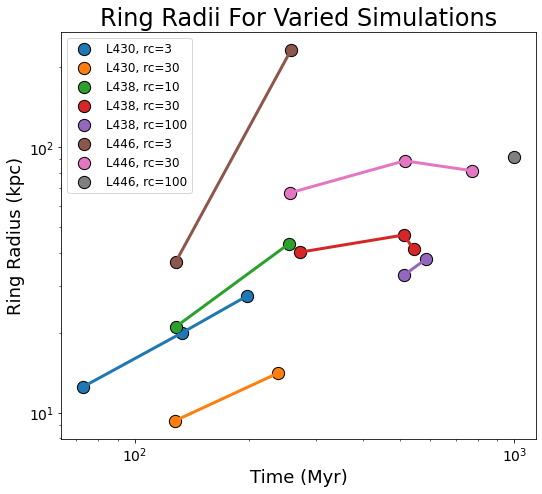

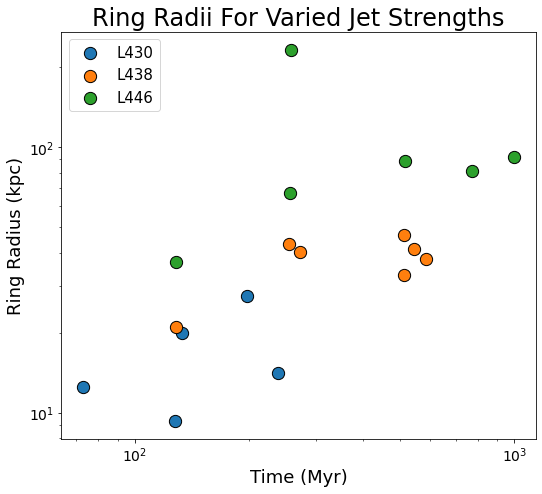

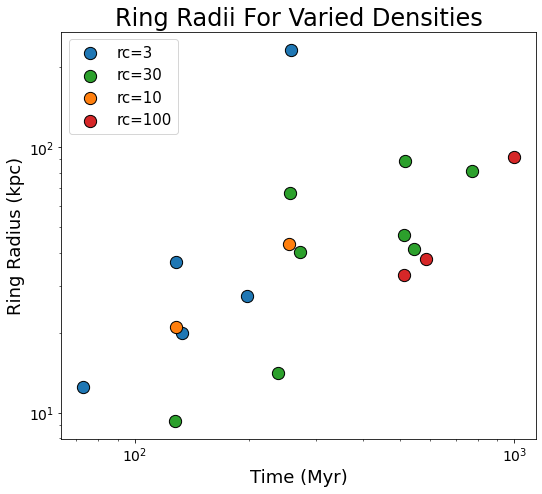

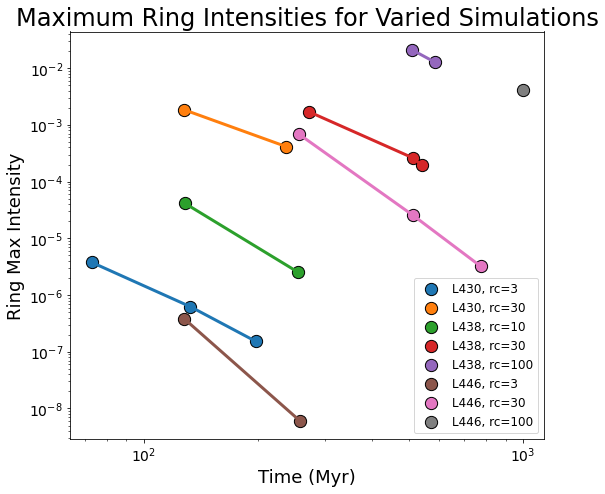

In [44]:

   
plt.rcParams["figure.figsize"] = (8.5,7.5)
for i in range(len(ring_r_mlst)):
    if len(ring_r_mlst[i]) > 0:
        #plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "rc={}".format(rc[i]), edgecolors = 'k')
        plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "L{}, rc={}".format(stren_lst[i], rc_lst[i]), s=150, edgecolors = 'k')
        plt.plot(ring_t_mlst[i], ring_r_mlst[i], linewidth = 3)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Time (Myr)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.ylabel("Ring Radius (kpc)", fontsize=18)
        plt.yticks(fontsize=14)
        plt.title("Ring Radii For Varied Simulations", fontsize=24)
        # plt.set_cmap("viridis") 
        # cb = plt.colorbar()
        # cb.set_label(label = "Intensity", weight='bold')        
    
plt.legend(loc = "upper left", prop={'size': 12})
plt.show()

l_colors = {430: "tab:blue", 438: "tab:orange", 446: "tab:green"}
c_colors = {3: "tab:blue", 10:  "tab:orange", 30:"tab:green", 100: "tab:red"}



prev_L = 0
for i in range(len(ring_r_mlst)):
    if len(ring_r_mlst[i]) > 0:
        #plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "rc={}".format(rc[i]), edgecolors = 'k')
        l_val = stren_lst[i]
        if stren_lst[i] != prev_L:
            plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "L{}".format(stren_lst[i]), s=150, edgecolors = 'k', color = l_colors[l_val])
        else:
            plt.scatter(ring_t_mlst[i], ring_r_mlst[i], s=150, edgecolors = 'k', color = l_colors[l_val])
        #plt.plot(ring_t_mlst[i], ring_r_mlst[i], linewidth = 3, color = l_colors[l_val])
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Time (Myr)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.ylabel("Ring Radius (kpc)", fontsize=18)
        plt.yticks(fontsize=14)
        plt.title("Ring Radii For Varied Jet Strengths", fontsize=24)
        
        prev_L = stren_lst[i]
plt.legend(loc = "upper left", prop={'size': 15})
plt.show()

prev_rc = []
for i in range(len(ring_r_mlst)):
    if len(ring_r_mlst[i]) > 0:
        #plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "rc={}".format(rc[i]), edgecolors = 'k')
        l_val = rc_lst[i]
        if rc_lst[i] not in prev_rc:
            plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "rc={}".format(rc_lst[i]), s=150, edgecolors = 'k', color = c_colors[l_val])
        else:
            plt.scatter(ring_t_mlst[i], ring_r_mlst[i], s=150, edgecolors = 'k', color = c_colors[l_val])
        #plt.plot(ring_t_mlst[i], ring_r_mlst[i], linewidth = 3, color = l_colors[l_val])
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Time (Myr)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.ylabel("Ring Radius (kpc)", fontsize=18)
        plt.yticks(fontsize=14)
        plt.title("Ring Radii For Varied Densities", fontsize=24)
        
        prev_rc.append(rc_lst[i])
plt.legend(loc = "upper left", prop={'size': 15})
plt.show()


for i in range(len(ring_r_mlst)):
    if len(ring_r_mlst[i]) > 0:
        #plt.scatter(ring_t_mlst[i], ring_r_mlst[i], label = "rc={}".format(rc[i]), edgecolors = 'k')
        plt.scatter(ring_t_mlst[i], ring_I_mlst[i], label = "L{}, rc={}".format(stren_lst[i], rc_lst[i]), s=150, edgecolors = 'k')
        plt.plot(ring_t_mlst[i], ring_I_mlst[i], linewidth = 3)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Time (Myr)", fontsize=18)
        plt.xticks(fontsize=14)
        plt.ylabel("Ring Max Intensity", fontsize=18)
        plt.yticks(fontsize=14)
        plt.title("Maximum Ring Intensities for Varied Simulations", fontsize=24)
        # plt.set_cmap("viridis") 
        # cb = plt.colorbar()
        # cb.set_label(label = "Intensity", weight='bold')        
    
plt.legend(loc = "lower right", prop={'size': 12})
plt.show()


In [43]:
print(ring_t_mlst)
print("\n")
print(ring_r_mlst)
print("\n")
print(ring_I_mlst)
print("\n")
print(stren_lst)
print("\n")
print(rc_lst)
print("\n")

[[72.9, 132.8, 197.1], [], [127.6, 237.6], [], [128.1, 254.6], [271.9, 511.9, 541.9], [510.6, 585.7], [127.9, 257.7], [], [256.1, 513.1, 773.1], [998.1], [], [], []]


[[12.5094, 19.9632, 27.4818], [], [9.3334, 14.0734], [], [21.0651, 43.2644], [40.1857, 46.6672, 41.1579], [32.8939, 37.9376], [36.8639, 231.7157], [], [67.2462, 88.7163, 81.4246], [91.9571], [], [], []]


[[3.7747149340674312e-06, 6.220993478168475e-07, 1.531321199565616e-07], [], [0.0018560264046411108, 0.00041353320832429943], [], [4.1763138826904636e-05, 2.5500291870349022e-06], [0.001718723505100799, 0.00026219453319571115, 0.00019373185904876292], [0.020900893291352373, 0.012745854132964632], [3.814146229843879e-07, 6.0915558757672145e-09], [], [0.000692201108801365, 2.5313941975706705e-05, 3.2114154751779377e-06], [0.004067894016878902], [], [], []]


[430, 430, 430, 438, 438, 438, 438, 446, 446, 446, 446, 456, 456, 456]


[3, 10, 30, 3, 10, 30, 100, 3, 10, 30, 100, 3, 30, 100]




In [5]:
ring_data = np.array([["Strength", "rc", "Time", "Ring Radius (kpc)", "Maximum Ring Intensity"]])

for i in range(len(ring_r_mlst)):
    if len(ring_r_mlst[i]) > 0:
        ring_t_sub = ring_t_mlst[i]
        ring_r_sub = ring_r_mlst[i]
        ring_I_sub = ring_I_mlst[i]
        for j in range(len(ring_r_mlst[i])):
            cur_data = np.array([stren_lst[i], rc_lst[i], ring_t_sub[j], ring_r_sub[j], ring_I_sub[j]])
            ring_data = np.vstack([ring_data, cur_data])

data_table = pd.DataFrame(ring_data)

print(data_table)

           0      1      2                  3                       4
0   Strength     rc   Time  Ring Radius (kpc)  Maximum Ring Intensity
1      430.0    3.0   72.9            12.5094  3.7747149340674312e-06
2      430.0    3.0  132.8            19.9632   6.220993478168475e-07
3      430.0    3.0  197.1            27.4818   1.531321199565616e-07
4      430.0   30.0  127.6             9.3334   0.0018560264046411108
5      430.0   30.0  237.6            14.0734  0.00041353320832429943
6      438.0   10.0  128.1            21.0651  4.1763138826904636e-05
7      438.0   10.0  254.6            43.2644  2.5500291870349022e-06
8      438.0   30.0  271.9            40.1857    0.001718723505100799
9      438.0   30.0  511.9            46.6672  0.00026219453319571115
10     438.0   30.0  541.9            41.1579  0.00019373185904876292
11     438.0  100.0  510.6            32.8939    0.020900893291352373
12     438.0  100.0  585.7            37.9376    0.012745854132964632
13     446.0    3.0 

 0      1      2                  3                       4
0   Strength     rc   Time  Ring Radius (kpc)  Maximum Ring Intensity
1      430.0    3.0   72.9            12.5094  3.7747149340674312e-06
2      430.0    3.0  132.8            19.9632   6.220993478168475e-07
3      430.0    3.0  197.1            27.4818   1.531321199565616e-07
4      430.0   30.0  127.6             9.3334   0.0018560264046411108
5      430.0   30.0  237.6            14.0734  0.00041353320832429943
6      438.0   10.0  128.1            21.0651  4.1763138826904636e-05
7      438.0   10.0  254.6            43.2644  2.5500291870349022e-06
8      438.0   30.0  271.9            40.1857    0.001718723505100799
9      438.0   30.0  511.9            46.6672  0.00026219453319571115
10     438.0   30.0  541.9            41.1579  0.00019373185904876292
11     438.0  100.0  510.6            32.8939    0.020900893291352373
12     438.0  100.0  585.7            37.9376    0.012745854132964632
13     446.0    3.0  127.9            36.8639   3.814146229843879e-07
14     446.0    3.0  257.7           231.7157  6.0915558757672145e-09
15     446.0   30.0  256.1            67.2462    0.000692201108801365
16     446.0   30.0  513.1            88.7163  2.5313941975706705e-05
17     446.0   30.0  773.1            81.4246  3.2114154751779377e-06
18     446.0  100.0  998.1            91.9571    0.004067894016878902
